## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
def Normalize_Calculation(dataset):
  train_transform = transforms.Compose([transforms.ToTensor()])
  train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
  mean = train_set.data.mean(axis=(0,1,2))/255
  std = train_set.data.std(axis=(0,1,2))/255
  return mean, std

mean,std = Normalize_Calculation(datasets.CIFAR10)
print("Mean - ", mean,"  ","Standard Deviation - ",std)

Files already downloaded and verified
Mean -  [0.49139968 0.48215841 0.44653091]    Standard Deviation -  [0.24703223 0.24348513 0.26158784]


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                       ])

# Dataset and Creating Train/Test Split

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)
# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

# The model
Let's start with the model we first saw

In [6]:
dropout_value = 0.01

def norm_layer(norm, parameter):
    if norm == "BN":
        return(nn.BatchNorm2d(parameter[0]))
    else:
        raise ValueError('Options are BN / LN / GN')


class Net(nn.Module):
    def __init__(self, norm="BN"):
        super(Net, self).__init__()
        self.norm = norm

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1,bias = False),
            norm_layer(self.norm, [8, 32, 32]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1,bias = False),
            norm_layer(self.norm, [16, 32, 32]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.tr1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0,bias = False),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1,bias = False),
            norm_layer(self.norm, [16, 16, 16]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1,bias = False),
            norm_layer(self.norm, [32, 16, 16]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1,bias = False),
            norm_layer(self.norm, [32, 16, 16]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.tr2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0,bias = False),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0,bias = False),
            norm_layer(self.norm, [16, 8, 6]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0,bias = False),
            norm_layer(self.norm, [32, 6, 4]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0,bias = False),
            norm_layer(self.norm, [64, 4, 2]),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0,bias = False),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(dropout_value)
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = self.tr1(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)

        x = self.tr2(x)
        x = self.pool2(x)

        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
       BatchNorm2d-2            [-1, 8, 32, 32]              16
           Dropout-3            [-1, 8, 32, 32]               0
              ReLU-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
       BatchNorm2d-6           [-1, 16, 32, 32]              32
           Dropout-7           [-1, 16, 32, 32]               0
              ReLU-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             128
             ReLU-10            [-1, 8, 32, 32]               0
        MaxPool2d-11            [-1, 8, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           1,152

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


# Let's Train and test our model

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.0610706806182861 Batch_id=390 Accuracy=41.71: 100%|██████████| 391/391 [00:21<00:00, 18.45it/s]



Test set: Average loss: 0.0112, Accuracy: 4728/10000 (47.28%)

EPOCH: 1


Loss=1.395017385482788 Batch_id=390 Accuracy=57.17: 100%|██████████| 391/391 [00:20<00:00, 19.16it/s]



Test set: Average loss: 0.0090, Accuracy: 5971/10000 (59.71%)

EPOCH: 2


Loss=1.0154937505722046 Batch_id=390 Accuracy=62.91: 100%|██████████| 391/391 [00:17<00:00, 22.88it/s]



Test set: Average loss: 0.0083, Accuracy: 6338/10000 (63.38%)

EPOCH: 3


Loss=1.1653831005096436 Batch_id=390 Accuracy=66.96: 100%|██████████| 391/391 [00:17<00:00, 22.41it/s]



Test set: Average loss: 0.0078, Accuracy: 6574/10000 (65.74%)

EPOCH: 4


Loss=0.8565545082092285 Batch_id=390 Accuracy=68.77: 100%|██████████| 391/391 [00:18<00:00, 21.33it/s]



Test set: Average loss: 0.0070, Accuracy: 6842/10000 (68.42%)

EPOCH: 5


Loss=0.7396833300590515 Batch_id=390 Accuracy=71.00: 100%|██████████| 391/391 [00:17<00:00, 22.58it/s]



Test set: Average loss: 0.0079, Accuracy: 6440/10000 (64.40%)

EPOCH: 6


Loss=0.7562090754508972 Batch_id=390 Accuracy=72.53: 100%|██████████| 391/391 [00:18<00:00, 20.62it/s]



Test set: Average loss: 0.0069, Accuracy: 6980/10000 (69.80%)

EPOCH: 7


Loss=0.9506210088729858 Batch_id=390 Accuracy=73.66: 100%|██████████| 391/391 [00:17<00:00, 22.46it/s]



Test set: Average loss: 0.0065, Accuracy: 7150/10000 (71.50%)

EPOCH: 8


Loss=0.9631674885749817 Batch_id=390 Accuracy=74.87: 100%|██████████| 391/391 [00:17<00:00, 22.43it/s]



Test set: Average loss: 0.0066, Accuracy: 7089/10000 (70.89%)

EPOCH: 9


Loss=0.8006378412246704 Batch_id=390 Accuracy=75.76: 100%|██████████| 391/391 [00:17<00:00, 22.64it/s]



Test set: Average loss: 0.0064, Accuracy: 7273/10000 (72.73%)

EPOCH: 10


Loss=0.6583135724067688 Batch_id=390 Accuracy=76.73: 100%|██████████| 391/391 [00:19<00:00, 20.44it/s]



Test set: Average loss: 0.0062, Accuracy: 7332/10000 (73.32%)

EPOCH: 11


Loss=0.9556894302368164 Batch_id=390 Accuracy=77.42: 100%|██████████| 391/391 [00:17<00:00, 22.31it/s]



Test set: Average loss: 0.0058, Accuracy: 7434/10000 (74.34%)

EPOCH: 12


Loss=0.5550199151039124 Batch_id=390 Accuracy=78.04: 100%|██████████| 391/391 [00:17<00:00, 22.62it/s]



Test set: Average loss: 0.0059, Accuracy: 7405/10000 (74.05%)

EPOCH: 13


Loss=0.763726532459259 Batch_id=390 Accuracy=78.63: 100%|██████████| 391/391 [00:18<00:00, 21.10it/s]



Test set: Average loss: 0.0060, Accuracy: 7429/10000 (74.29%)

EPOCH: 14


Loss=0.8403351902961731 Batch_id=390 Accuracy=79.18: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]



Test set: Average loss: 0.0059, Accuracy: 7453/10000 (74.53%)

EPOCH: 15


Loss=0.622339129447937 Batch_id=390 Accuracy=79.64: 100%|██████████| 391/391 [00:17<00:00, 22.70it/s]



Test set: Average loss: 0.0057, Accuracy: 7518/10000 (75.18%)

EPOCH: 16


Loss=0.4357406198978424 Batch_id=390 Accuracy=80.12: 100%|██████████| 391/391 [00:17<00:00, 21.84it/s]



Test set: Average loss: 0.0060, Accuracy: 7450/10000 (74.50%)

EPOCH: 17


Loss=0.45655351877212524 Batch_id=390 Accuracy=80.25: 100%|██████████| 391/391 [00:17<00:00, 22.33it/s]



Test set: Average loss: 0.0056, Accuracy: 7624/10000 (76.24%)

EPOCH: 18


Loss=0.4329497814178467 Batch_id=390 Accuracy=80.54: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]



Test set: Average loss: 0.0061, Accuracy: 7378/10000 (73.78%)

EPOCH: 19


Loss=0.6278111338615417 Batch_id=390 Accuracy=81.06: 100%|██████████| 391/391 [00:18<00:00, 21.15it/s]



Test set: Average loss: 0.0059, Accuracy: 7509/10000 (75.09%)



Text(0.5, 1.0, 'Test Accuracy')

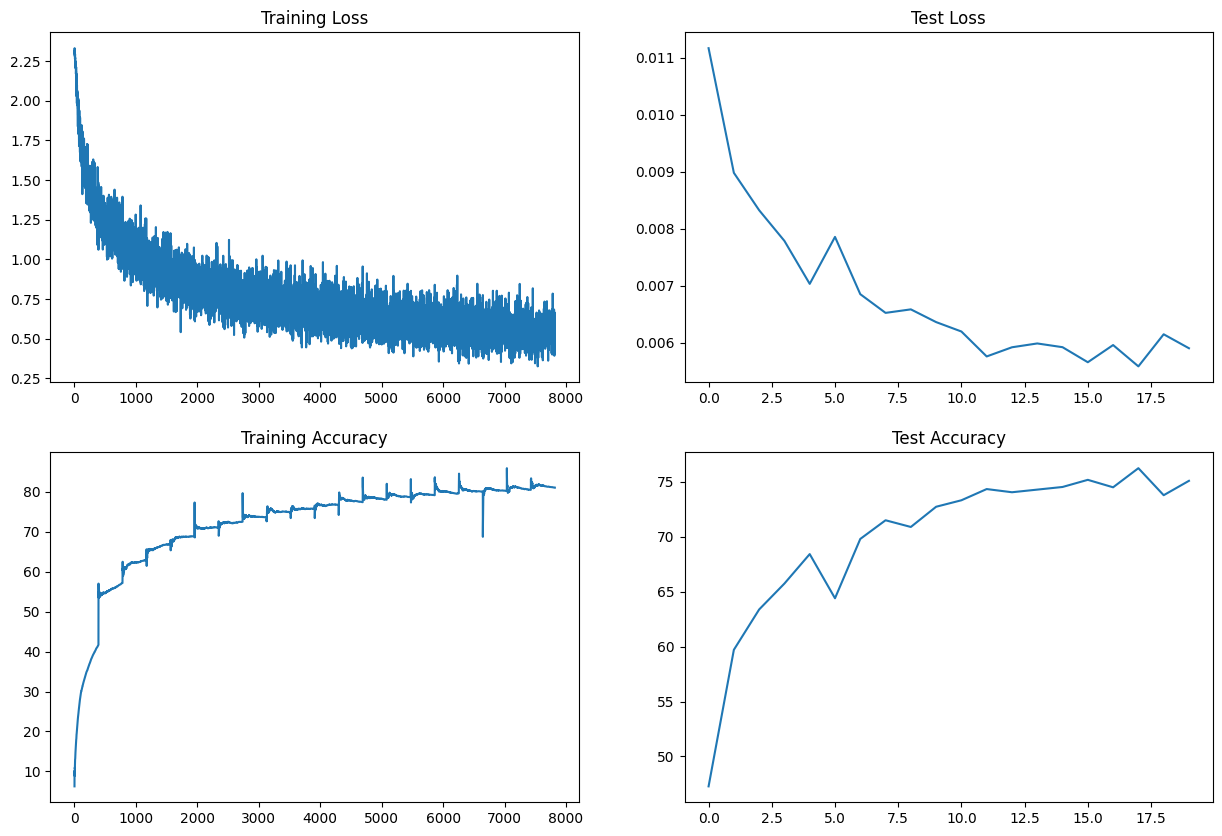

In [10]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")